In [1]:
# Author: Jaehun Kim
# Email: rlawogns1204@unist.ac.kr
# Affiliation: UNIST BME BCILAB
# Date: 2023-06-26
#
# This code implements a tactile information processing model using a spiking
# neural network (SNN). It simulates the processing of tactile information from
# mechanoreceptors in the skin through primary afferent fibers (PA), cuneate nucleus
# neurons (PN and IN), and ultimately, somatosensory cortex neurons. The model
# incorporates lateral inhibition and various receptive field properties to
# represent a realistic processing of touch stimuli.

# with DIGIT-sensor
# pip install torch==1.8.1+cu101 torchvision==0.9.1+cu101 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
from PIL import Image
import io
import datetime
import cv2
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

from Function.snn_IZHIlayers import *
from Function.snn_plot import *
from Function.snn_simulation import *
from Function.snn_stimulation import *
from Function.snn_receptive_field_weights import *

from line_profiler import LineProfiler
from tqdm import tqdm


%matplotlib inline
%load_ext autoreload
%autoreload 2

print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(f"Using device: {device}")\

# Set sensor dimensions (height and width in millimeters)
sensor_h, sensor_w = 19, 16
# Set pixel dimensions (number of pixels in height and width)
# pixel_h, pixel_w = 320, 240///
pixel_h, pixel_w = 64,48
# Set image frames per second (FPS) of tactile sensor
image_FPS = 60

ModuleNotFoundError: No module named 'torch'

In [2]:
# R = ReceptiveFieldWeights(pixel_h, pixel_w, device, type_output = (np.arange(0, np.pi, np.pi / 18) + np.pi / 2).tolist(), plot_receptive_field = False,plot_ind = 50)
R = ReceptiveFieldWeights(pixel_h, pixel_w, device, type_output = [0], plot_receptive_field = False,plot_ind = 50)

[0]
torch.Size([88, 3072])
sa_rf shape: torch.Size([88, 3072]) with height = 11 with width = 8
ra_rf shape: torch.Size([130, 3072]) with height = 13 with width = 10
sa_cn_pn_rf shape:  torch.Size([54, 88]) sa_cn_pn_step_height: 9 sa_cn_pn_step_width: 6
sa_cn_in_rf shape:  torch.Size([54, 88]) sa_cn_in_step_height: 9 sa_cn_in_step_width: 6
ra_cn_pn_rf shape:  torch.Size([88, 130]) ra_cn_pn_step_height: 11 ra_cn_pn_step_width: 8
ra_cn_in_rf shape:  torch.Size([88, 130]) ra_cn_in_step_height: 11 ra_cn_in_step_width: 8
sa_intopn_rf shape:  torch.Size([54, 54])
ra_intopn_rf shape:  torch.Size([88, 88])
cn_pn_sa_rf shape:  torch.Size([28, 54]) cn_pn_sa_rf_step_height: 7 cn_pn_sa_rf_step_width: 4
cn_in_sa_rf shape:  torch.Size([28, 54]) cn_in_sa_rf_step_height: 7 cn_in_sa_rf_step_width: 4
cn_pn_ra_rf shape:  torch.Size([28, 88]) cn_pn_ra_rf_step_height: 7 cn_pn_ra_rf_step_width: 4
cn_in_ra_rf shape:  torch.Size([28, 88]) cn_in_ra_rf_step_height: 7 cn_in_ra_rf_step_width: 4
cn_intopn_rf shape:

c:\Users\JaehunKim\anaconda3\envs\pytorch-cpu-3.11\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


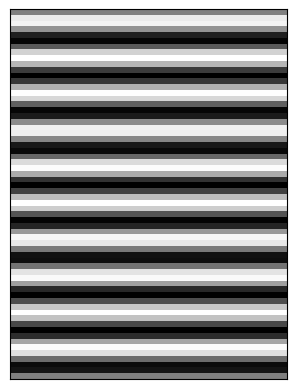

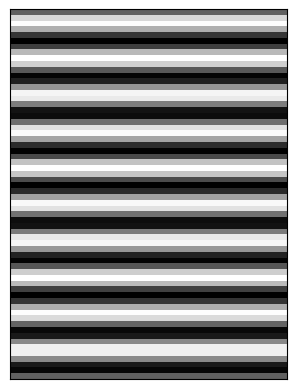

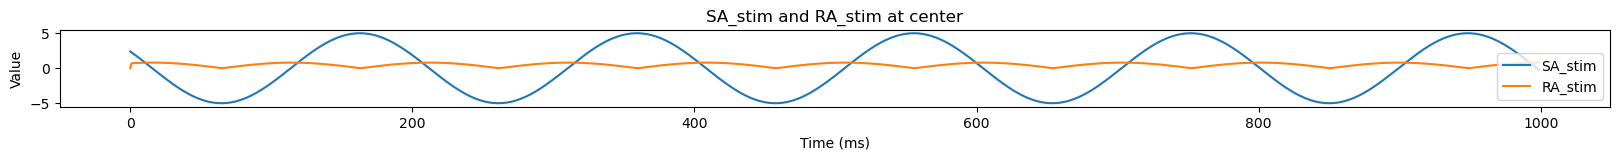

In [3]:
speed = 1
stim = generate_2d_sine_wave_stimulation(speed_mm_s=19 * speed,frequency= 10, amplitude = 5, plot_stimuli = True, show_frames = [0,400])

recording_stimulation(stim)

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

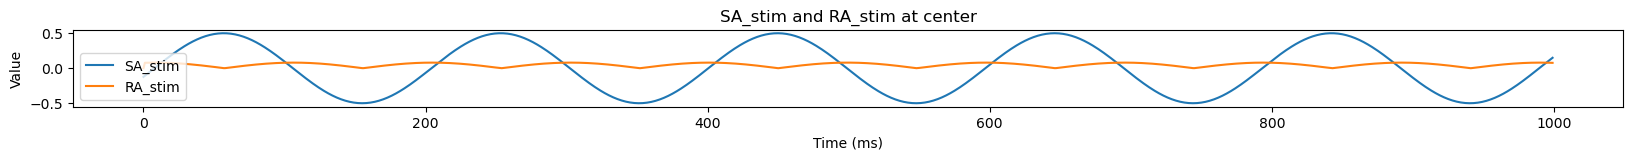

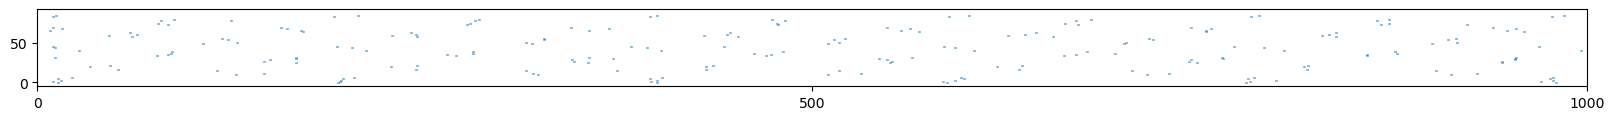

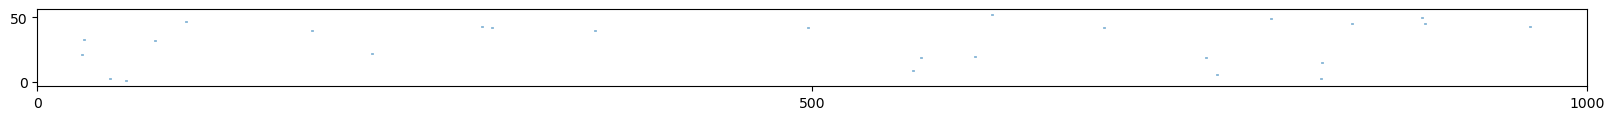

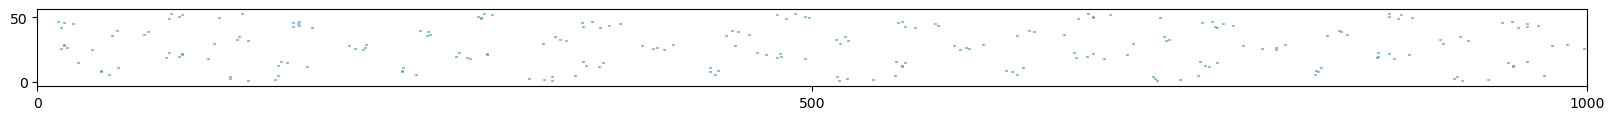

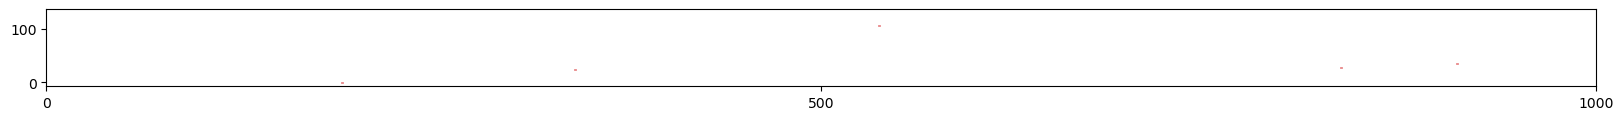

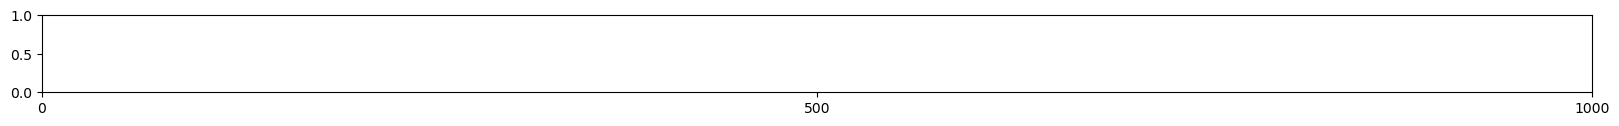

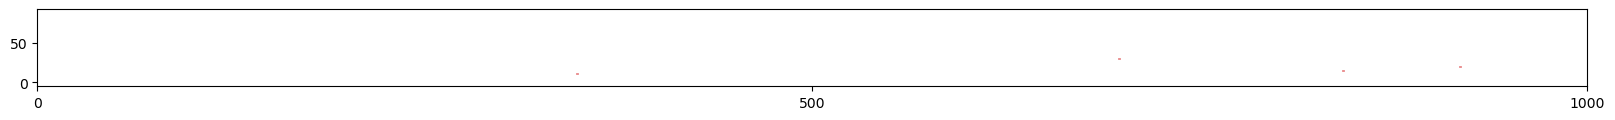

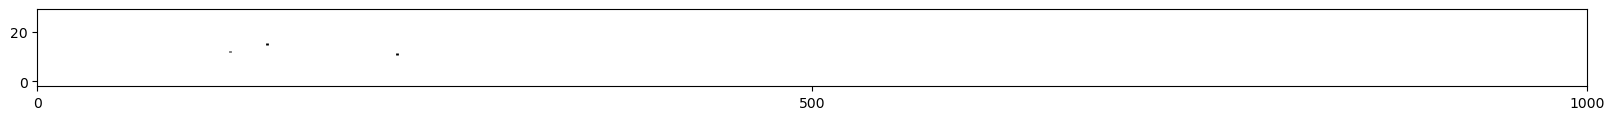

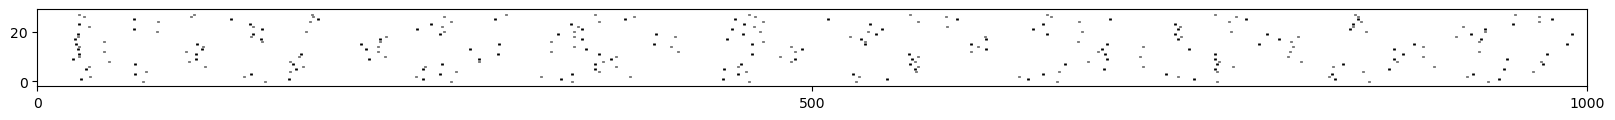

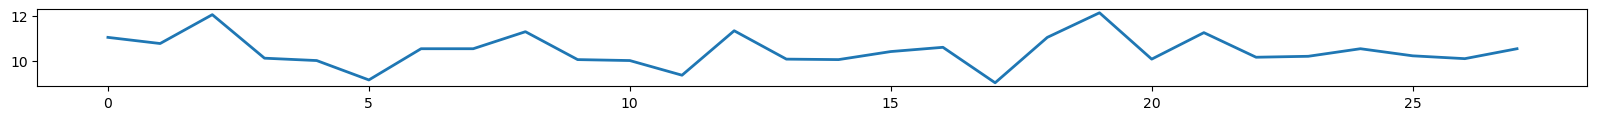

frequency:1 Hz    Mean Firing Rate(Hz): 10.442106246948242


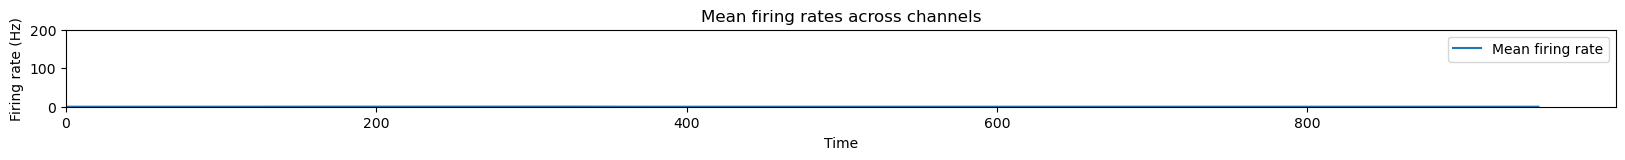

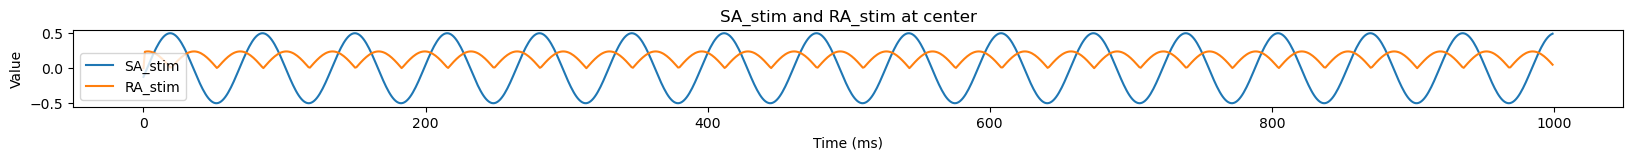

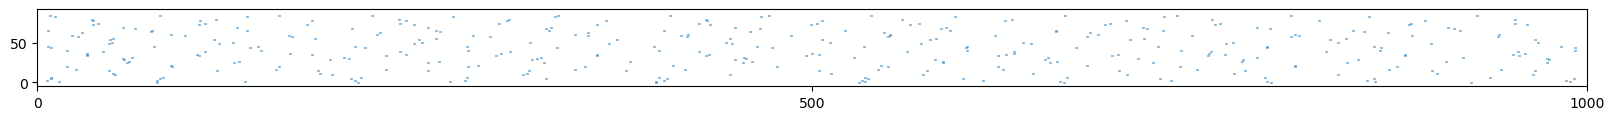

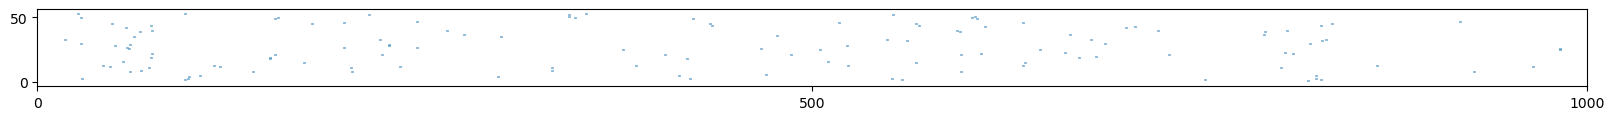

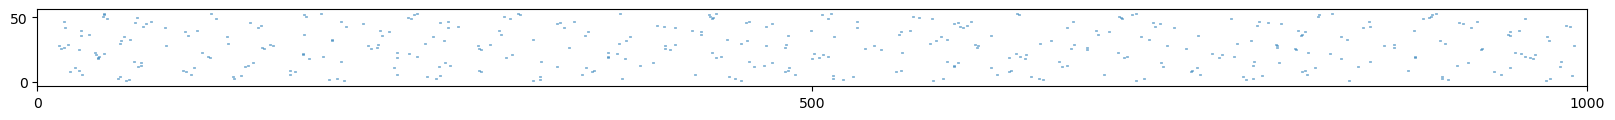

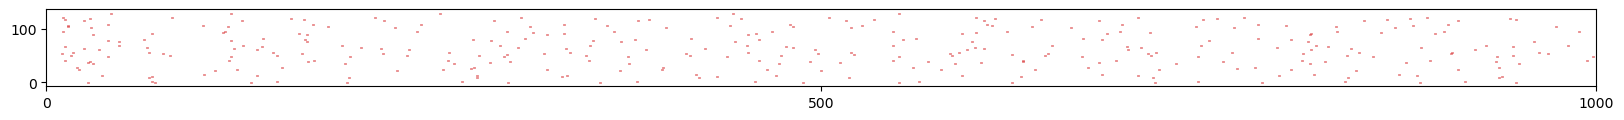

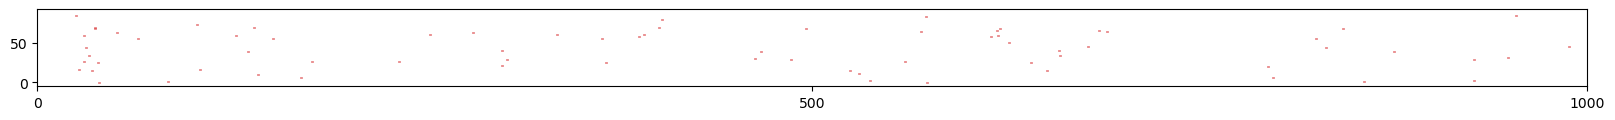

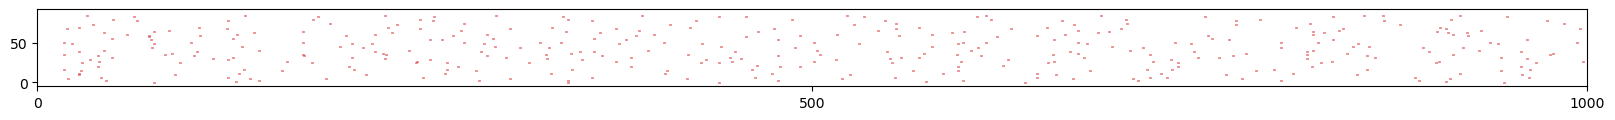

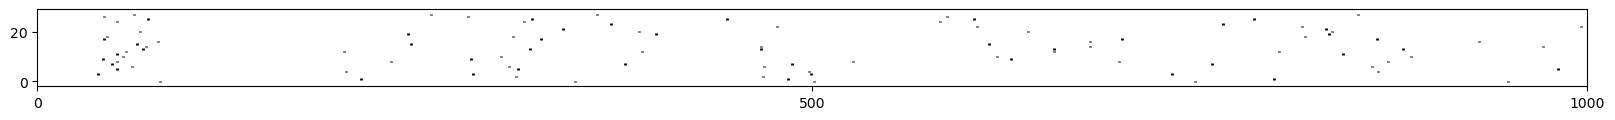

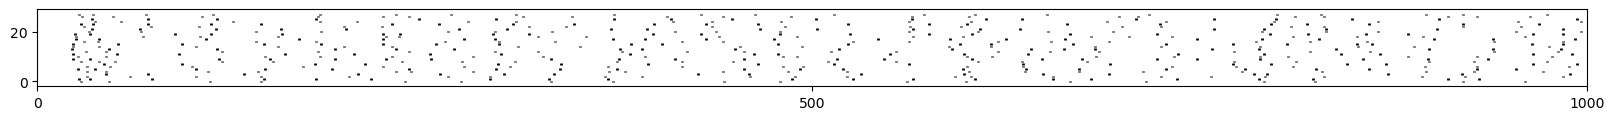

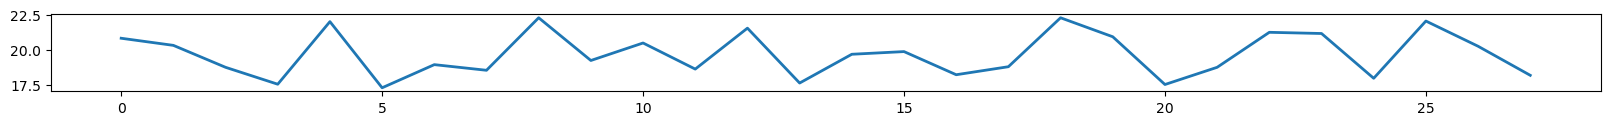

frequency:3 Hz    Mean Firing Rate(Hz): 19.69999885559082


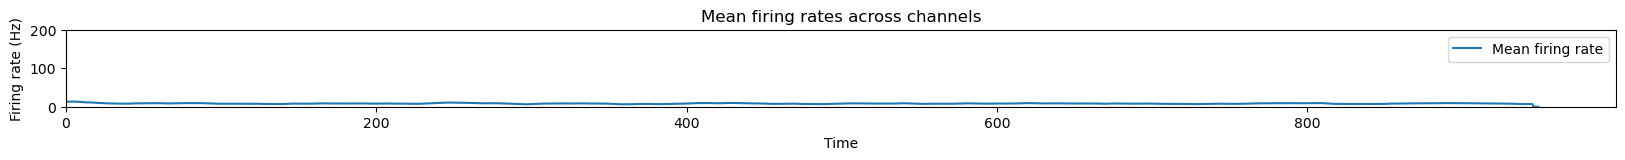

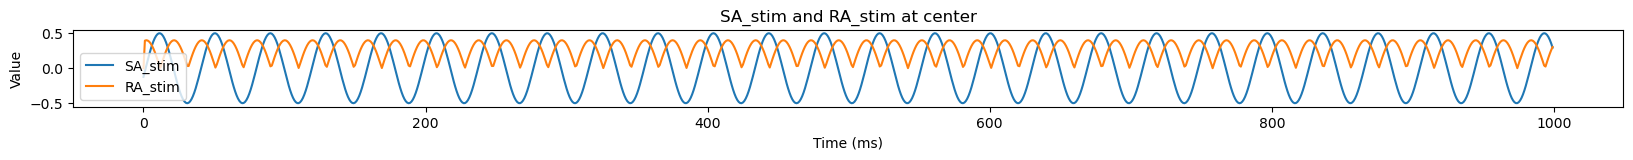

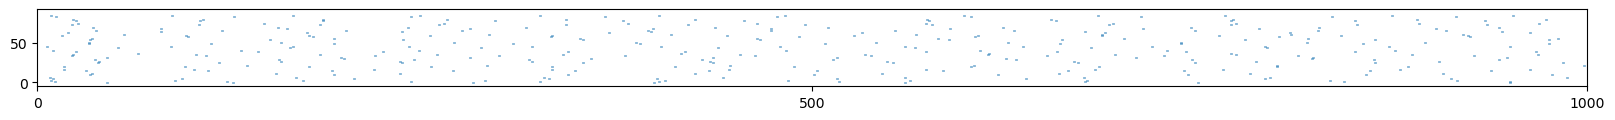

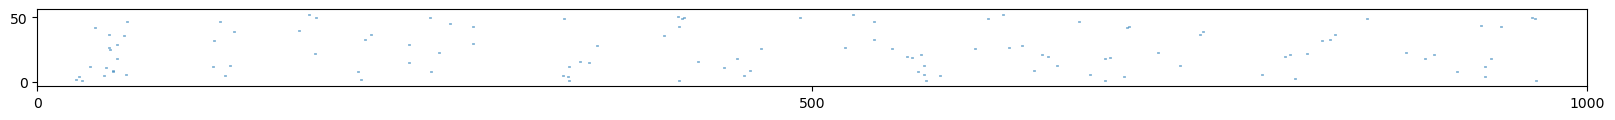

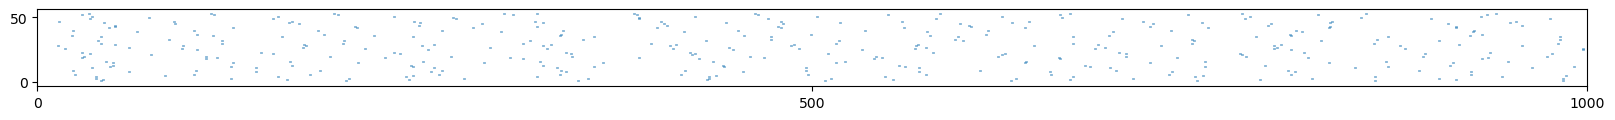

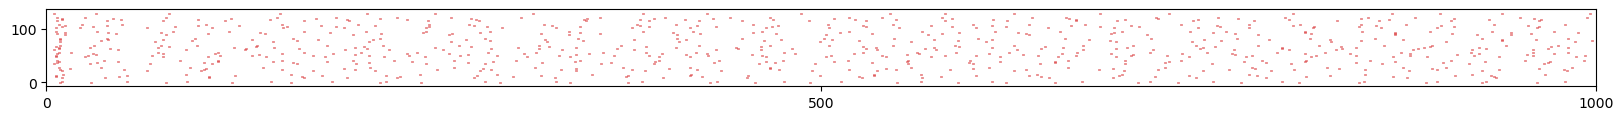

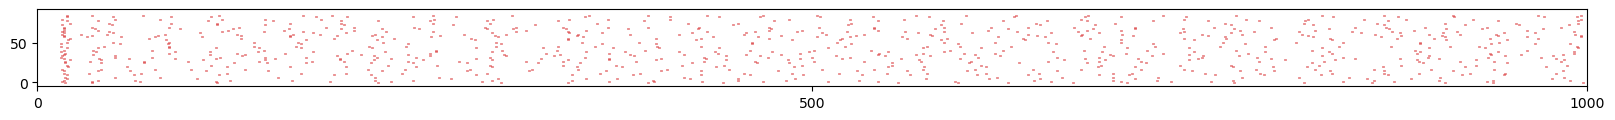

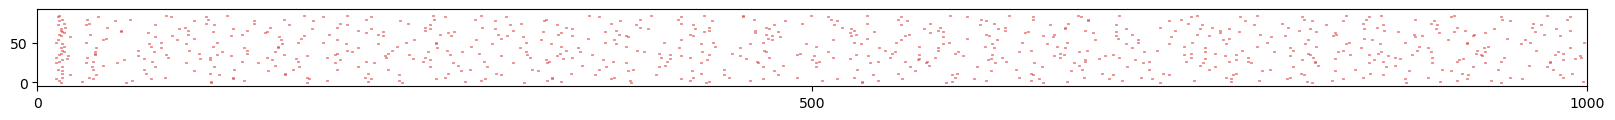

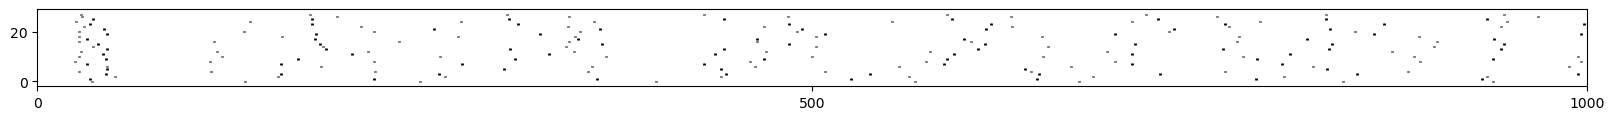

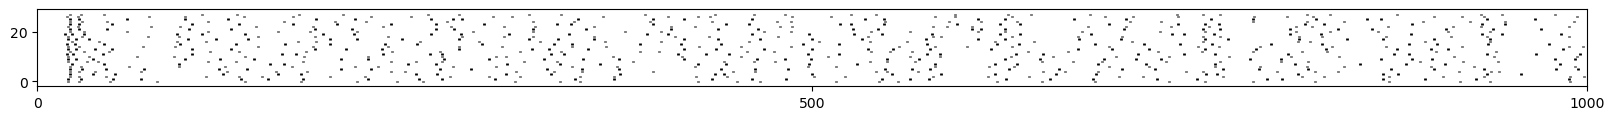

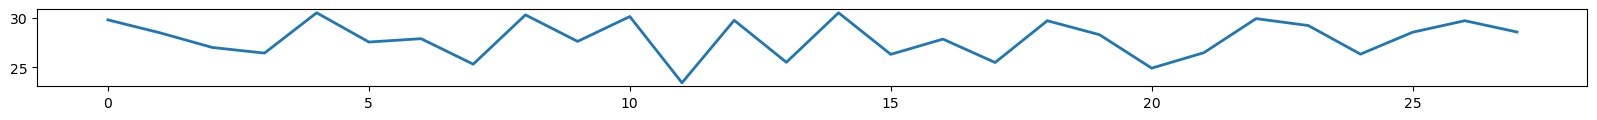

frequency:5 Hz    Mean Firing Rate(Hz): 27.915788650512695


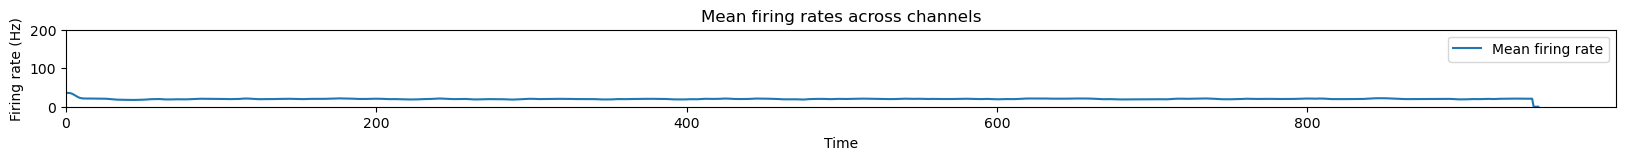

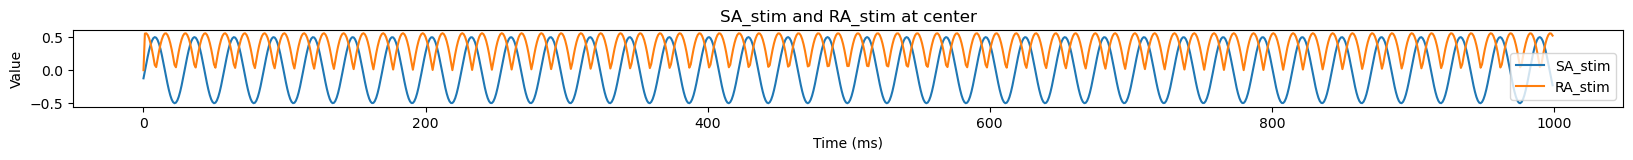

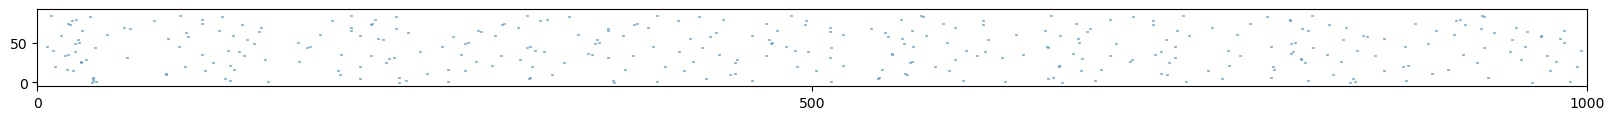

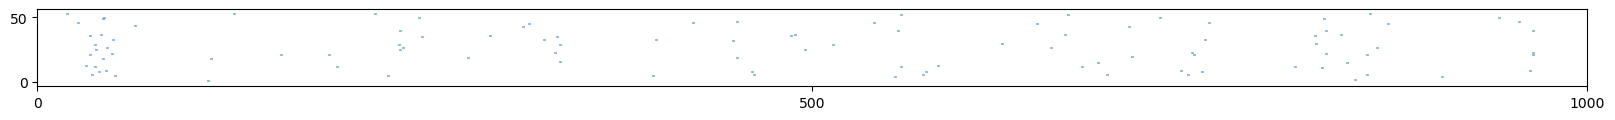

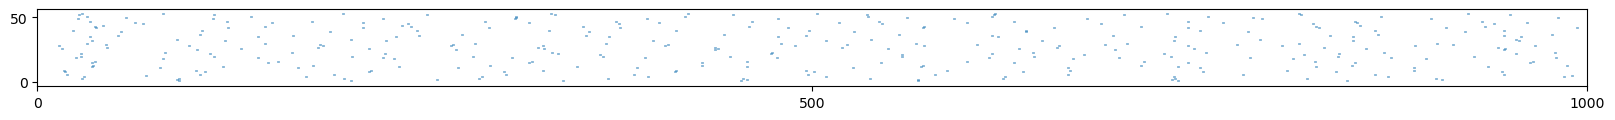

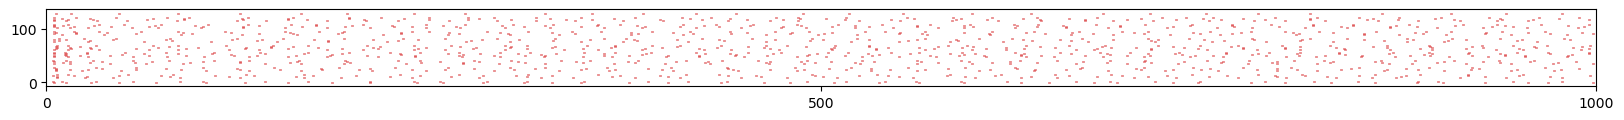

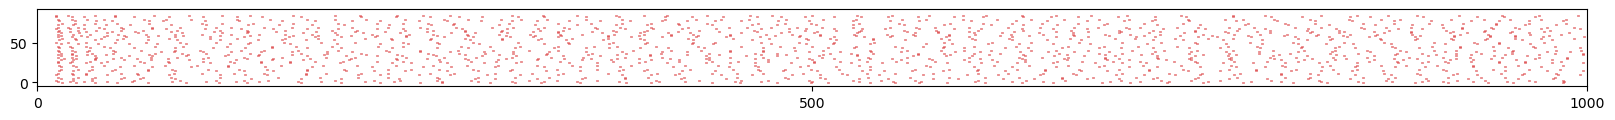

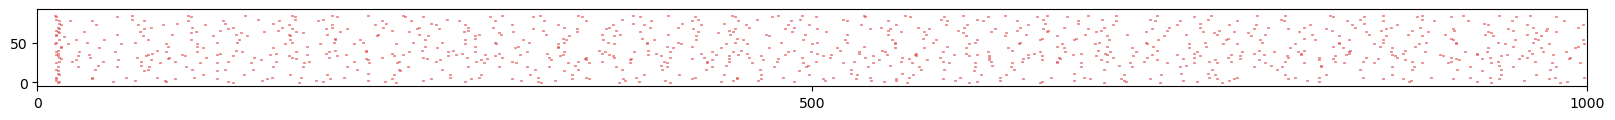

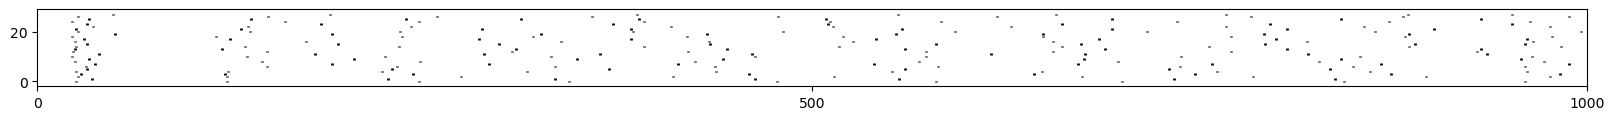

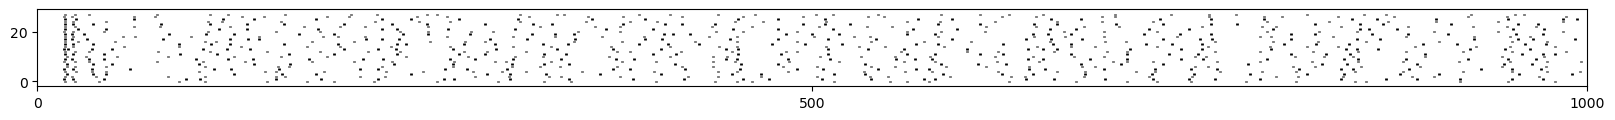

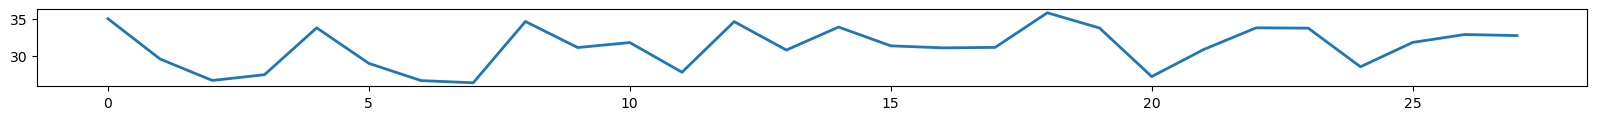

frequency:7 Hz    Mean Firing Rate(Hz): 31.203760147094727


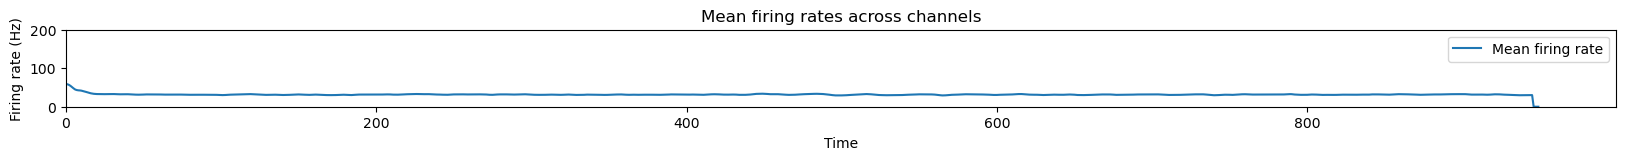

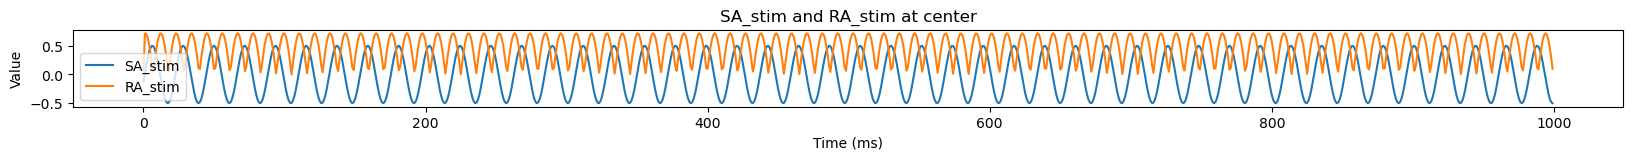

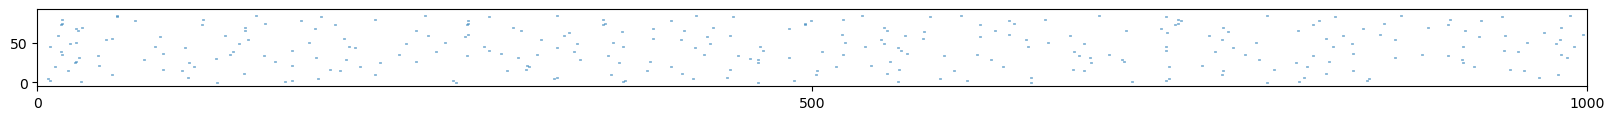

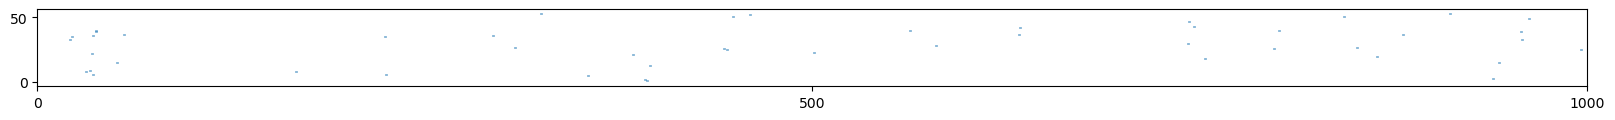

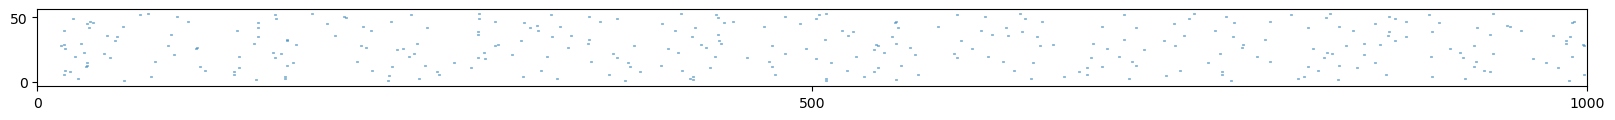

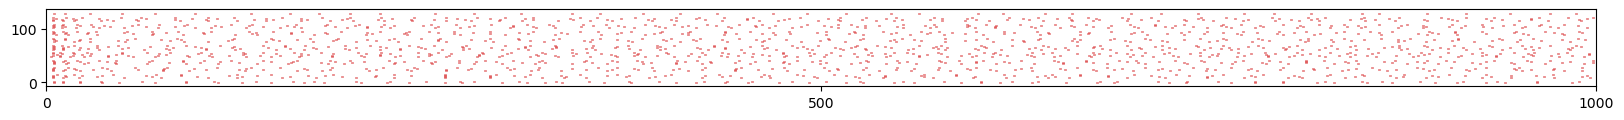

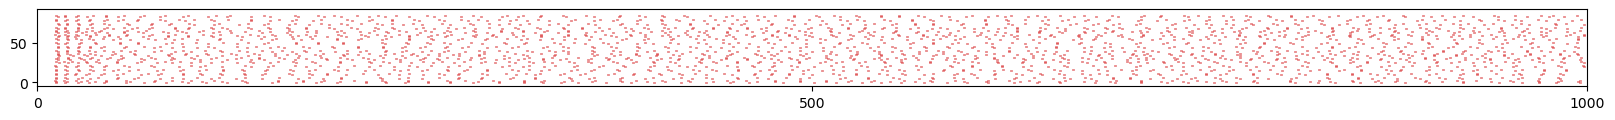

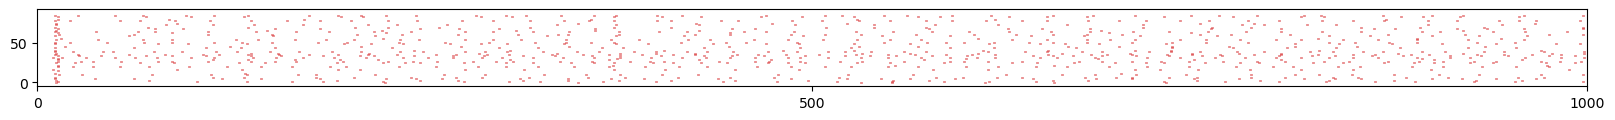

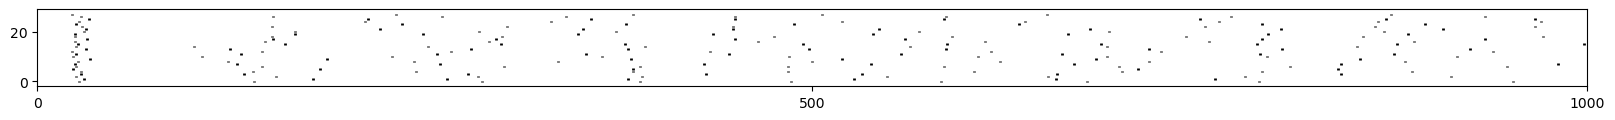

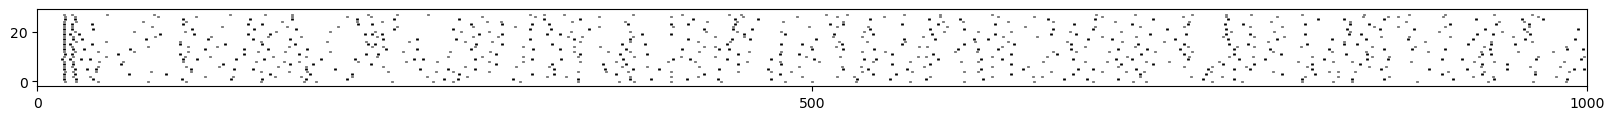

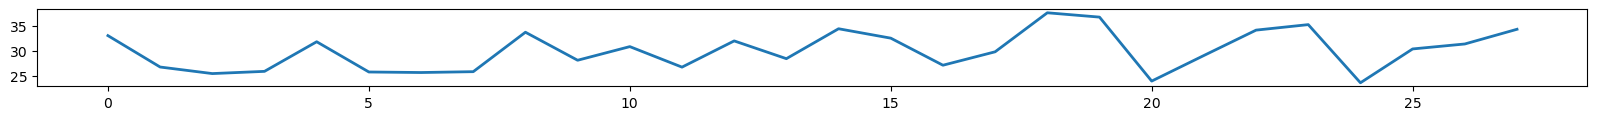

frequency:9 Hz    Mean Firing Rate(Hz): 30.078950881958008


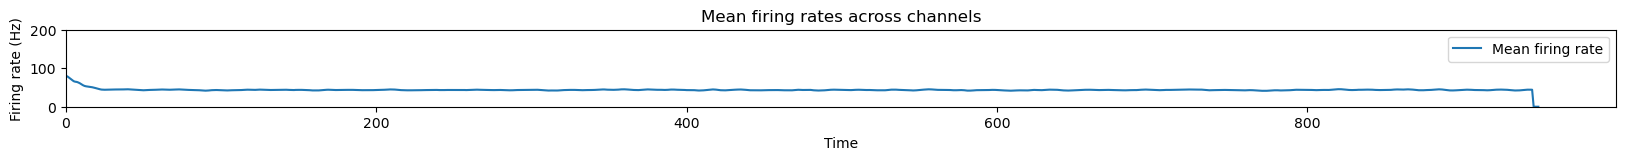

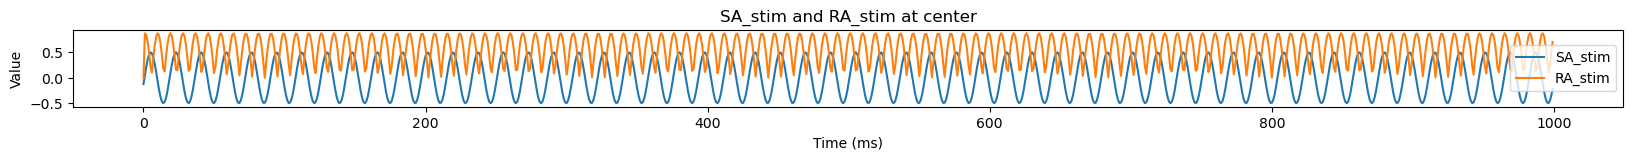

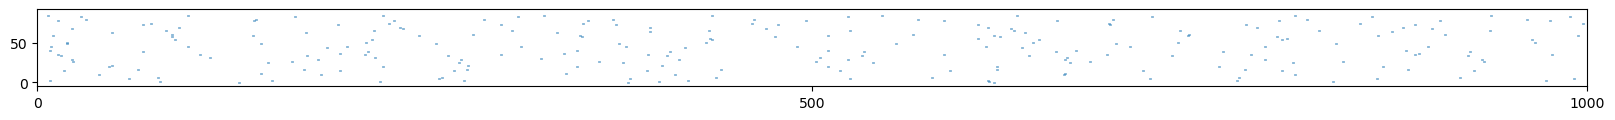

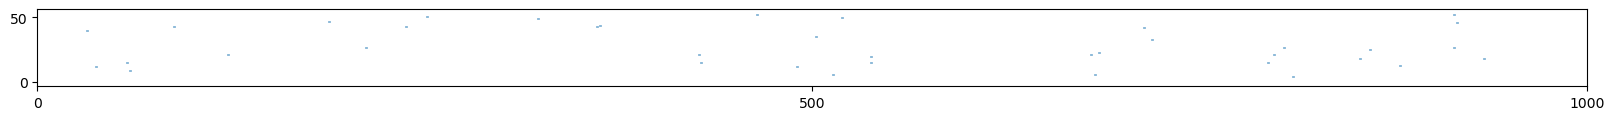

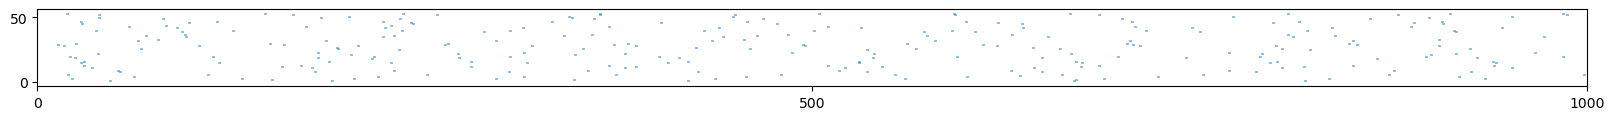

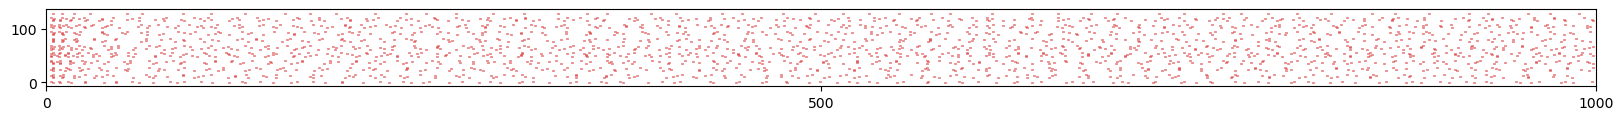

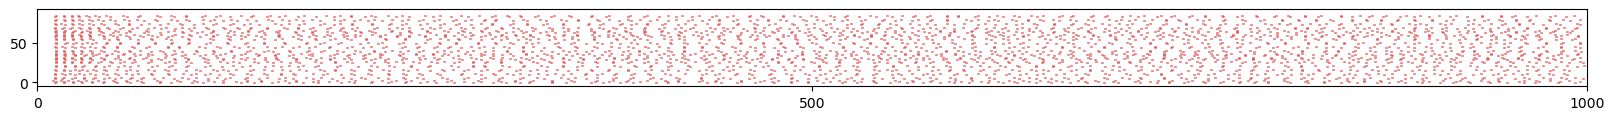

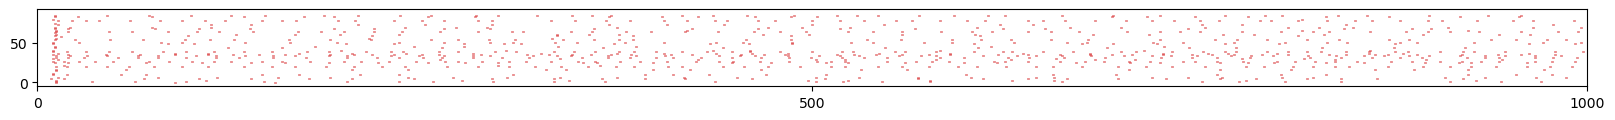

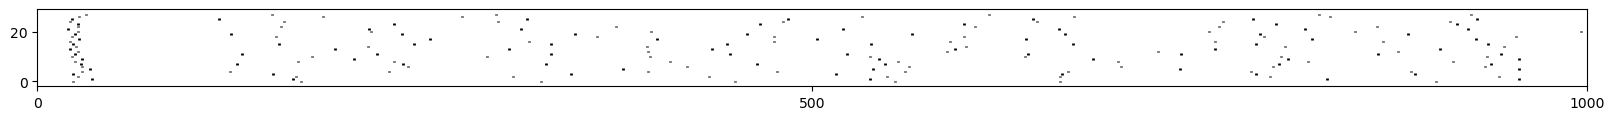

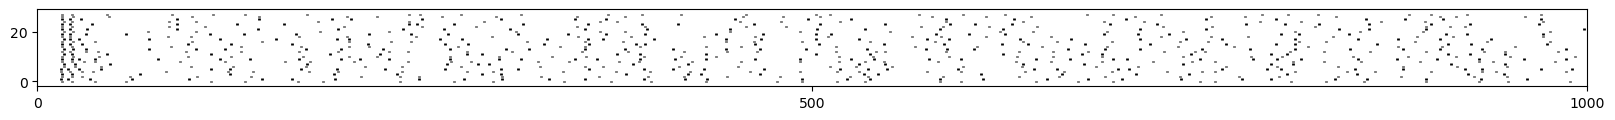

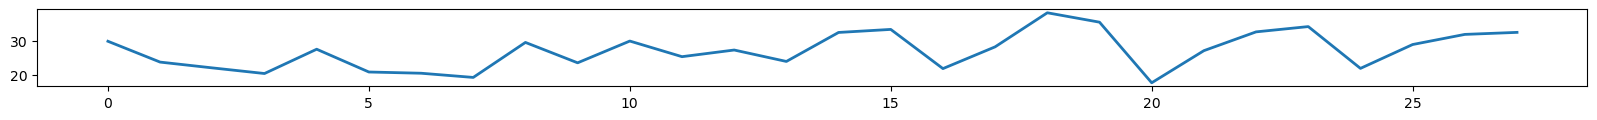

frequency:11 Hz    Mean Firing Rate(Hz): 27.092479705810547


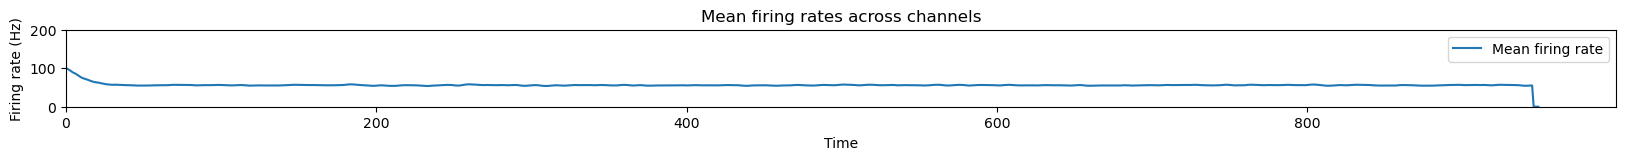

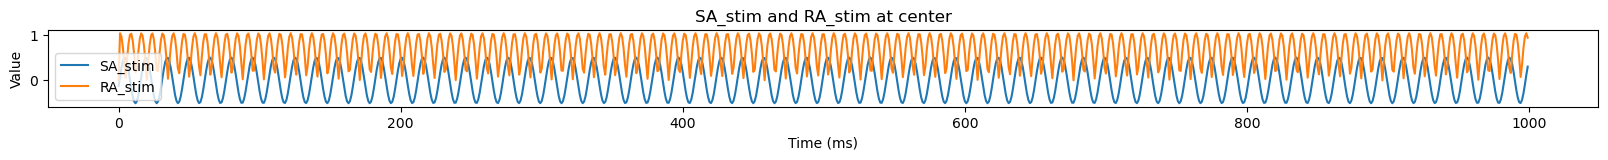

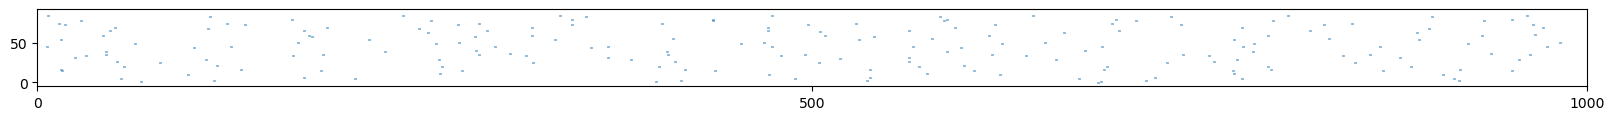

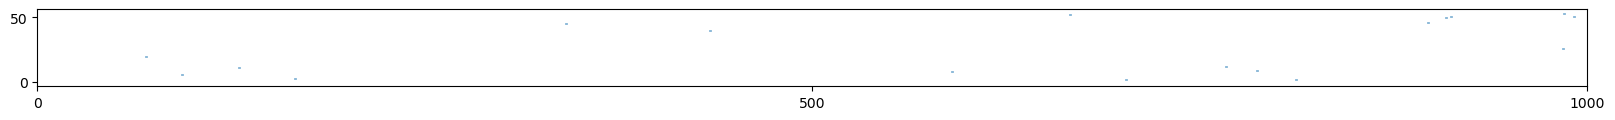

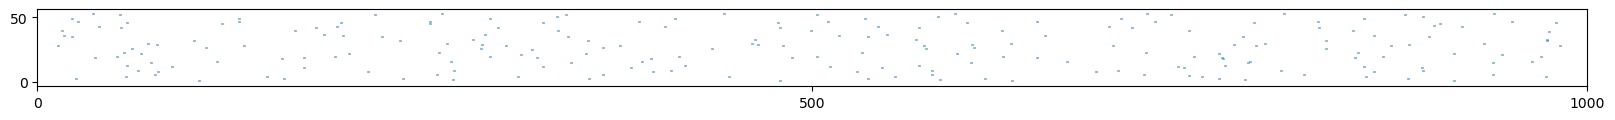

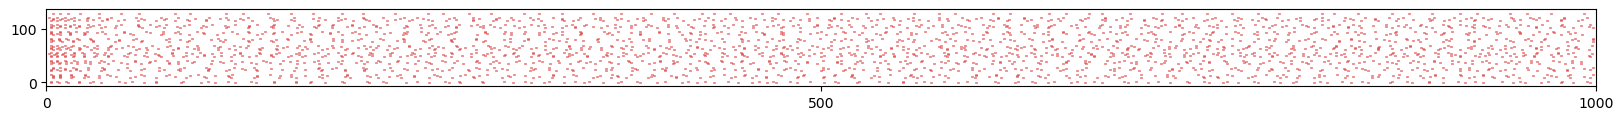

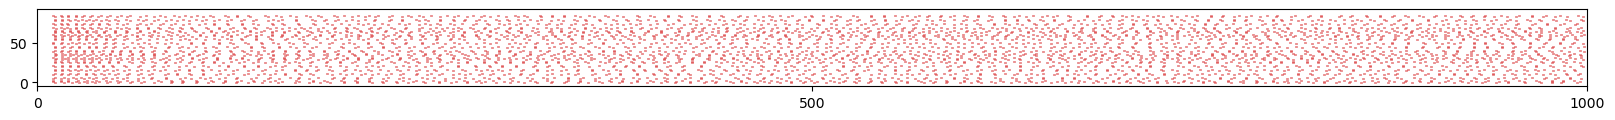

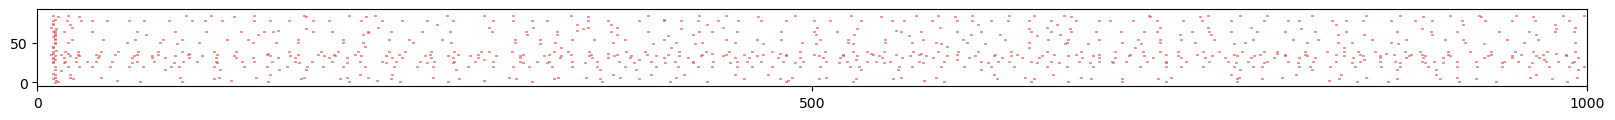

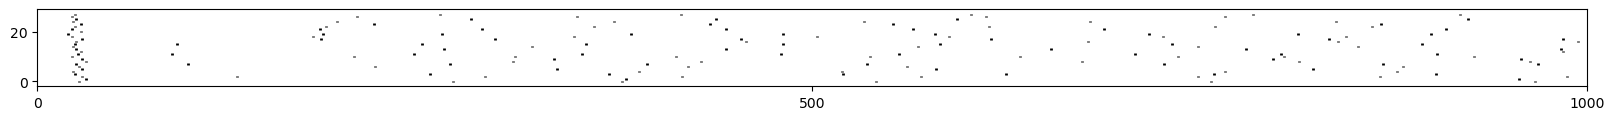

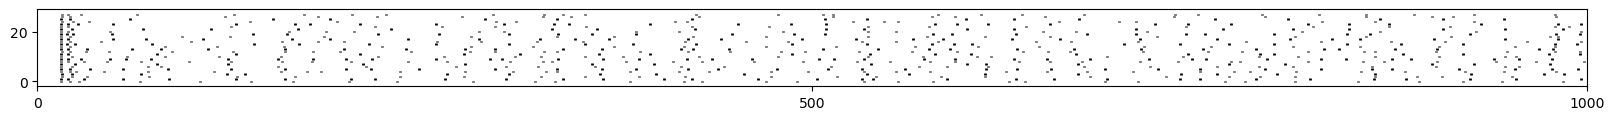

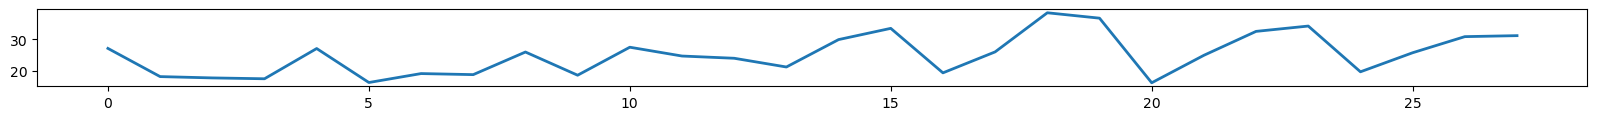

frequency:13 Hz    Mean Firing Rate(Hz): 25.065412521362305


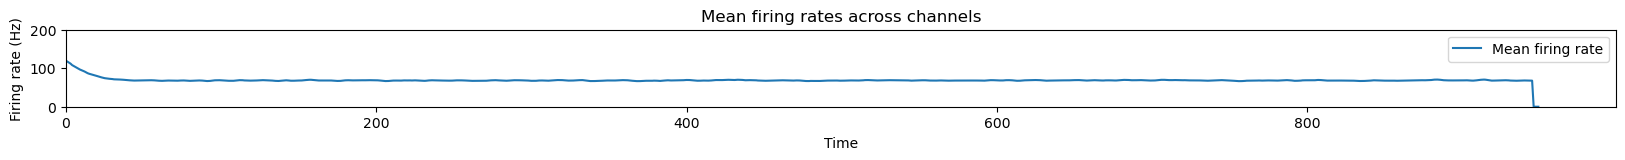

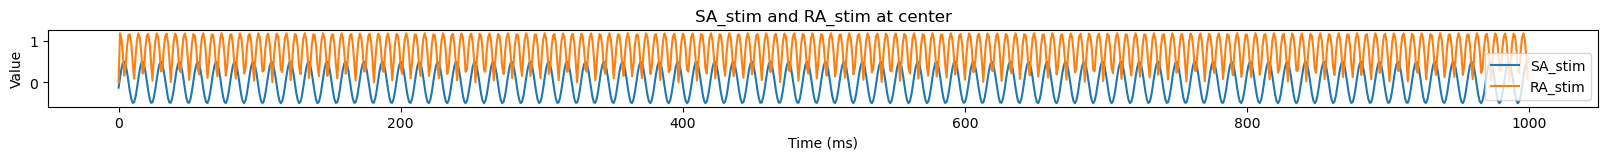

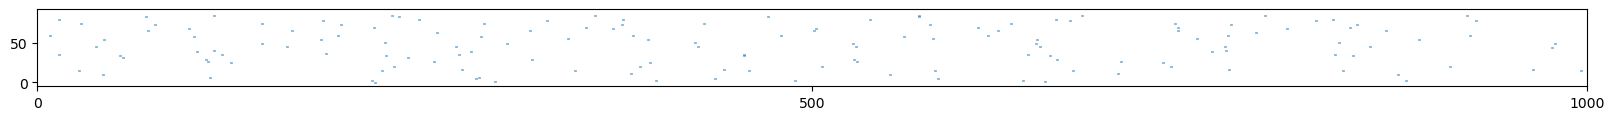

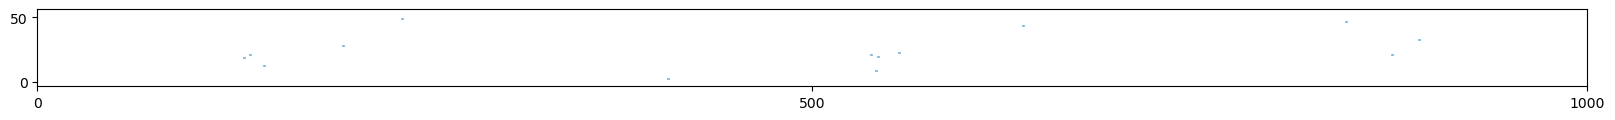

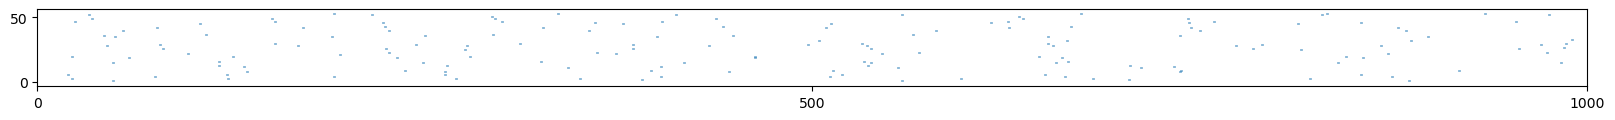

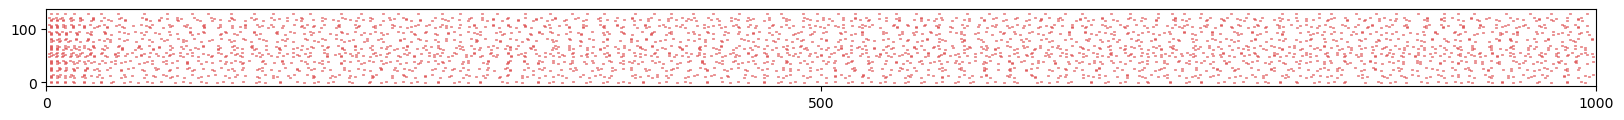

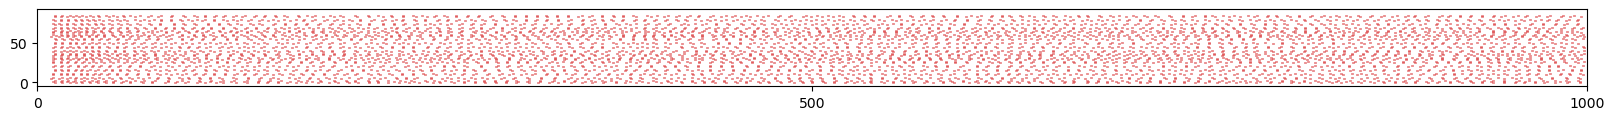

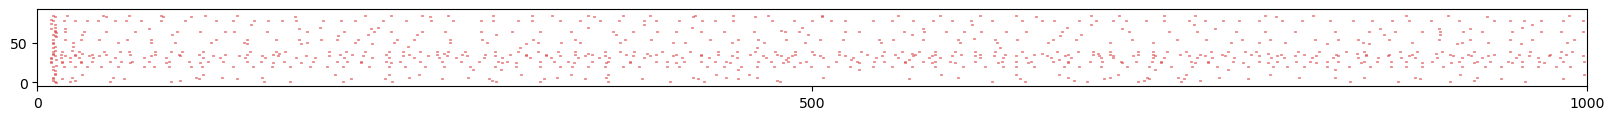

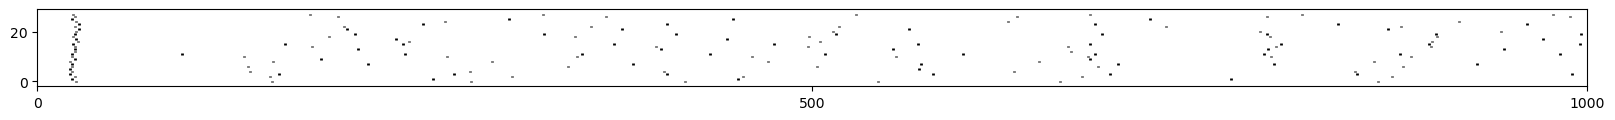

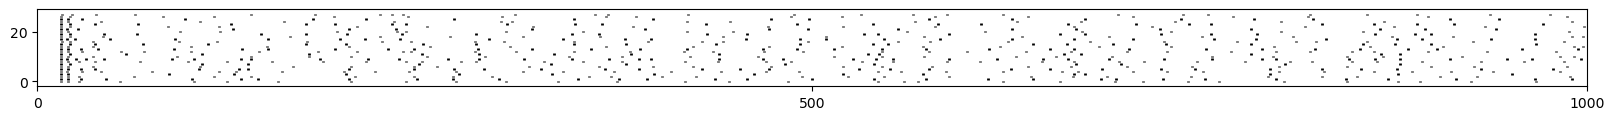

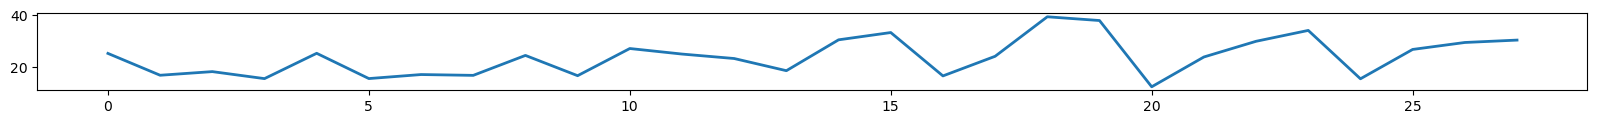

frequency:15 Hz    Mean Firing Rate(Hz): 23.972930908203125


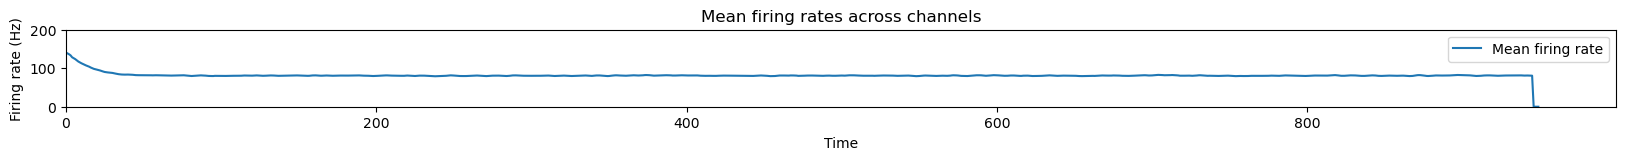

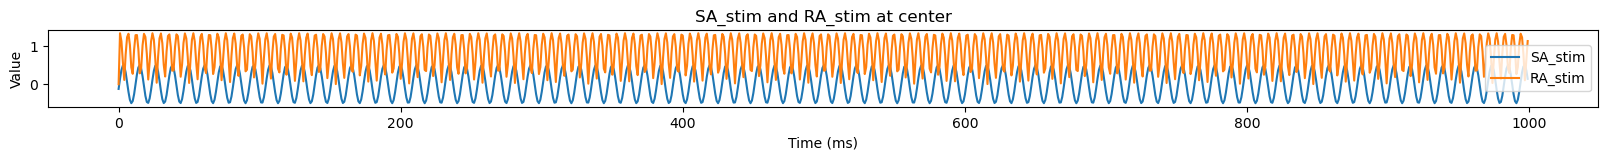

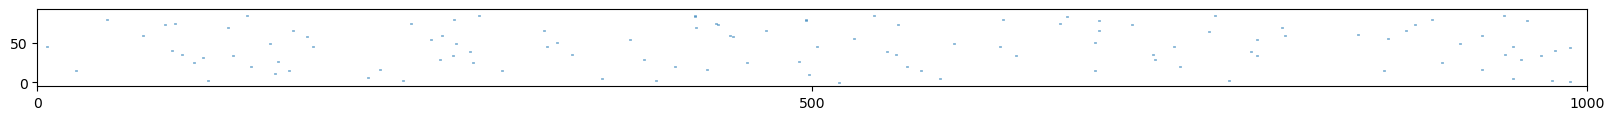

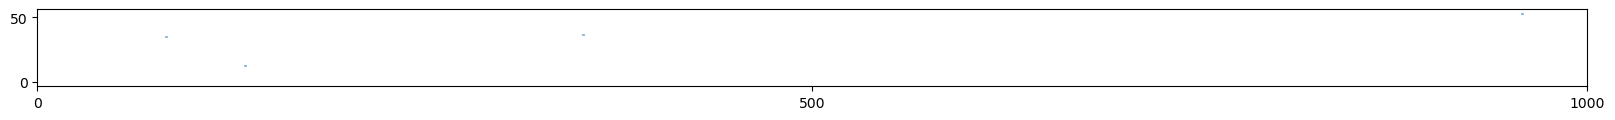

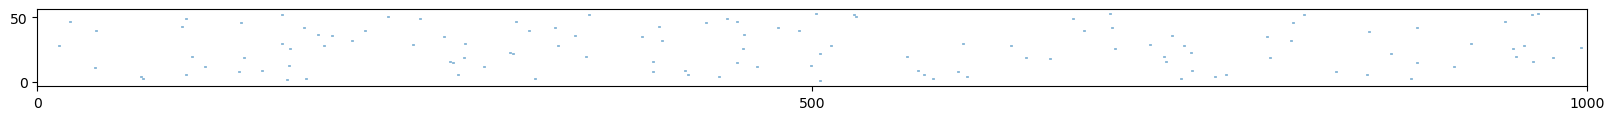

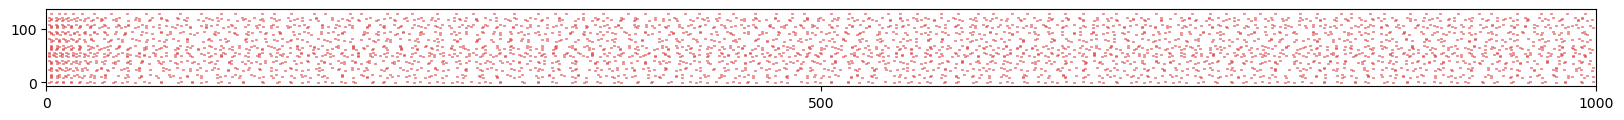

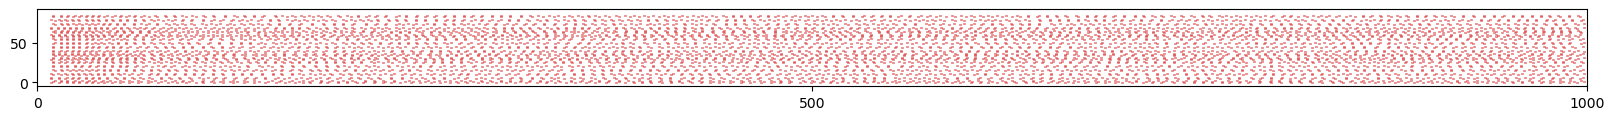

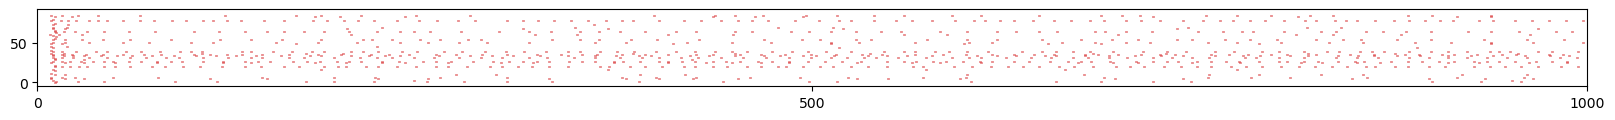

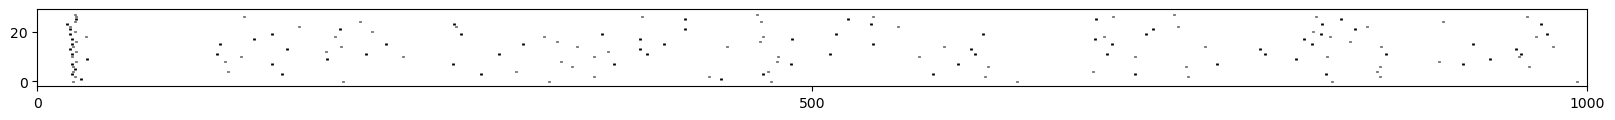

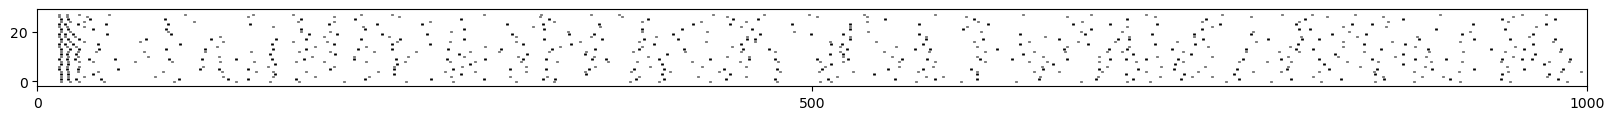

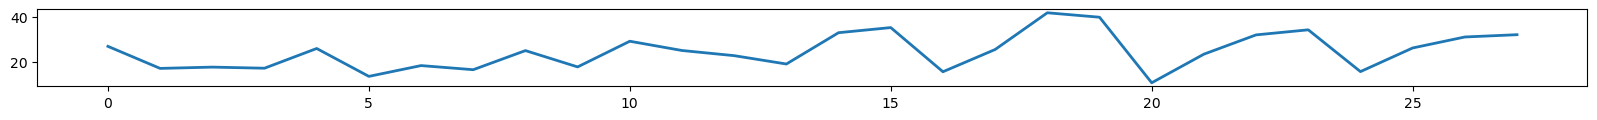

frequency:17 Hz    Mean Firing Rate(Hz): 24.58646583557129


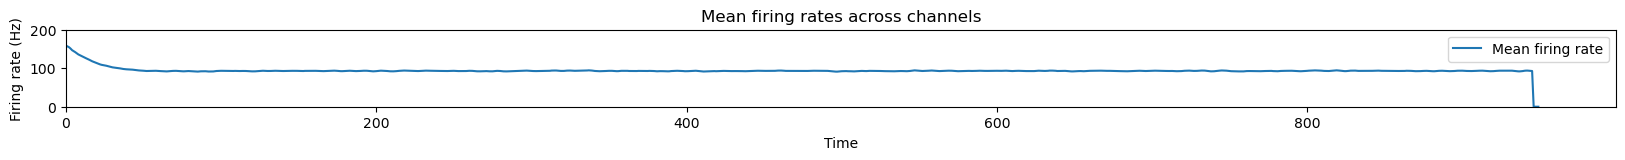

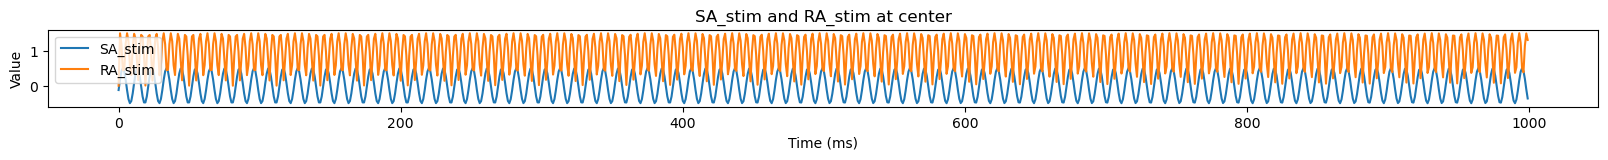

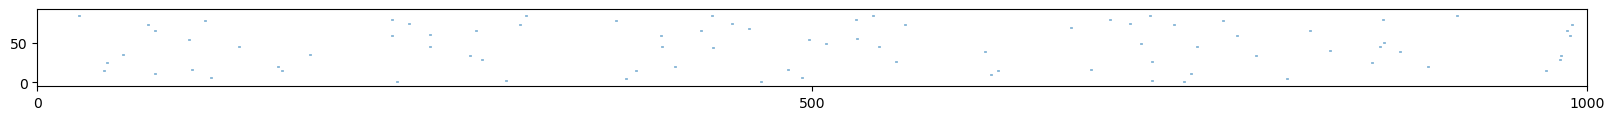

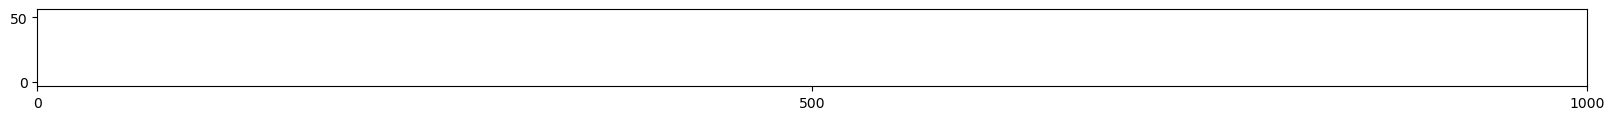

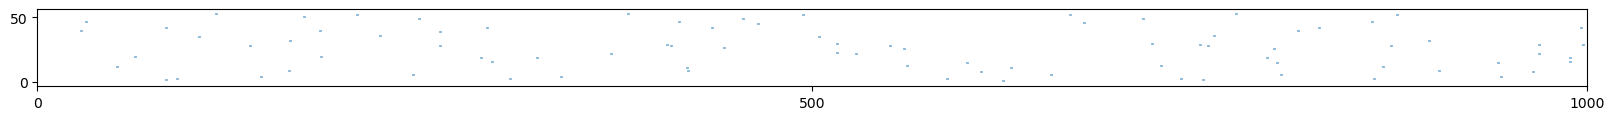

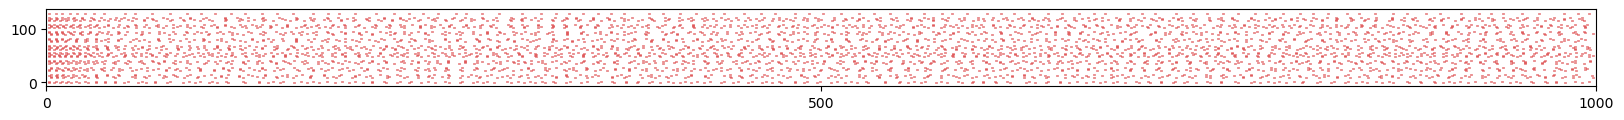

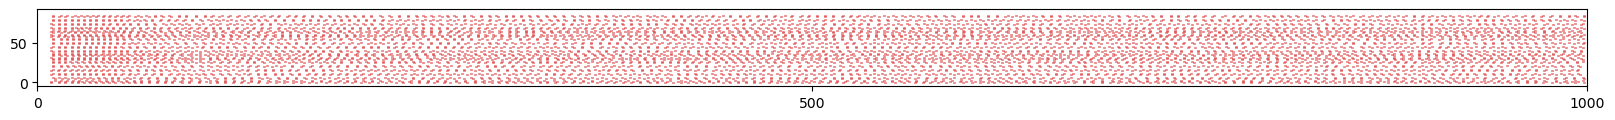

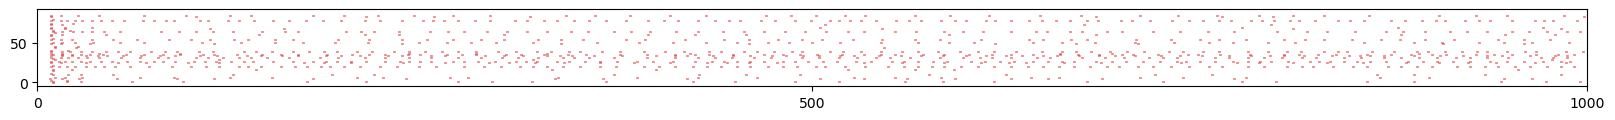

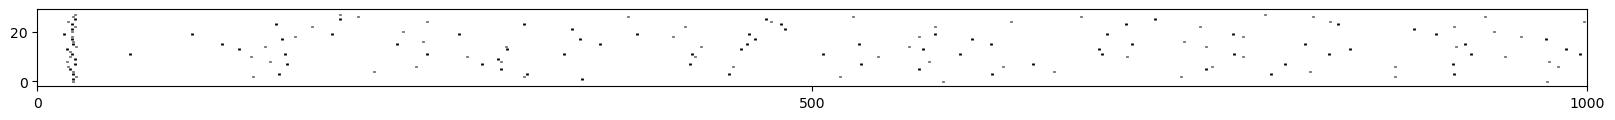

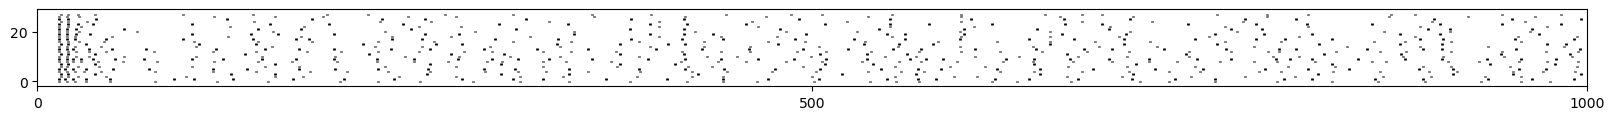

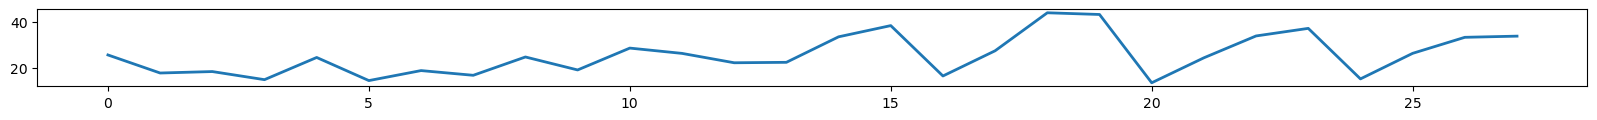

frequency:19 Hz    Mean Firing Rate(Hz): 25.560901641845703


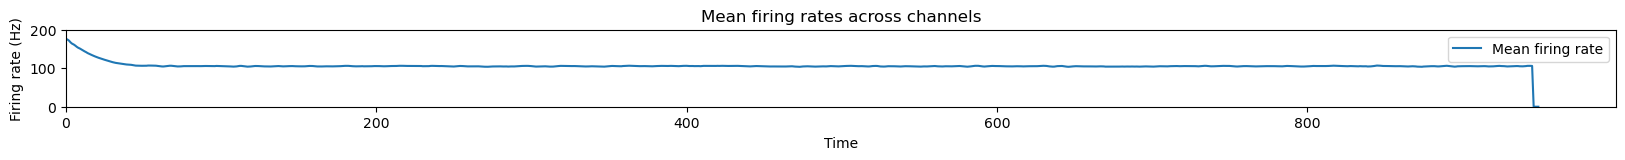

Trials: 100%|██████████| 1/1 [01:42<00:00, 102.70s/it]


In [4]:

num_trials = 1
num_frequencies = range(1,20, 2) # Frequencies from 80 to 100 with a step of 1
num_stim = 1000
F = 0.5 
pixel_h = 64
pixel_w = 48
device = 'cpu'  
data = []
labels = []

# Run the trials
for trial in tqdm(range(num_trials), desc="Trials"):
    # Generate the stimuli for each frequency
    for frequency in tqdm(num_frequencies, desc=f"Trial {trial+1} - Frequencies", leave=False):
        # Generate the stimulus
        stim = generate_2d_sine_wave_stimulation(speed_mm_s=19 * frequency, frequency= 5, amplitude = F, plot_stimuli = False, show_frames = [0,400])

        # plt.figure(figsize= (20,1))
        # plt.plot(stimulus[0, 0, :], linewidth=0.5)
        # plt.plot(torch.abs(torch.diff(stimulus[40, 40, :])) * 5, linewidth=0.5)
        # plt.title("Frequency: " + str(freq) + " Hz",fontsize = 12)
        # plt.tick_params(axis='both', which='major', labelsize=8)  # adjust the size here
        # plt.xlim([0, num_stim])
        # plt.show()

        S = SNN(R, device = device, noise_std_val = 2)  # Update with your SNN initialization method
        S.feedforward(stim)
        plot_figure = (trial == 0)

        mean_firing_rates = plot_SNN(S,layers = ['sa','ra','cn'],plot_figure = plot_figure,fig_size = (20,1))

        if trial == 0:
            print('frequency:' + str(frequency) +' Hz   ' + ' Mean Firing Rate(Hz): ' + str(torch.mean(mean_firing_rates).item()))
        # if trial == 1:
        
        #     mean_firing_rates = plot_SNN(S,layers=['cn'],plot_figure = True,fig_size = (20,1))
        
        plot_mean_firing_rates(S.ra_spike_times[0],bin_size = 50, fig_size = (20,1))

        # Save the data and labels
        data.append(mean_firing_rates.cpu().numpy())
        labels.append(frequency)
